## <span style="color:blue">Code groups: assessing regional litter survey results. Support text for presentation </span>

### <span style="color:#008891">Methods</span>
1. data collection
2. scope

### <span style="color:#008891">Summary data</span>
#### <span style="color:#008891">All surveys</span>

1. all data
2. project lakes

### <span style="color:#008891">Code groups</span>

1. summary data
2. components
3. survey results
4. monthly median and change
5. key values by lake

#### <span style="color:#008891">Code groups: Significant events</span>

1. definition
2. significant events per lake
3. frequency of ocurrence per group and lake

#### <span style="color:#008891">Regional assessment tools</span>

Find the locations on one lake that may be hotspots for litter accumulation. Identify the ones that may be interesting to monitor in the future. Use the provided graphic and map to make your decision.
    
    

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# convenience functions for tables
def make_table_grids(anax):
    anax.grid(False)
    anax.spines["top"].set_visible(False)
    anax.spines["right"].set_visible(False)
    anax.spines["bottom"].set_visible(False)
    anax.spines["left"].set_visible(False)
    return(anax)

def table_fonts(a_table, size=12):
    a_table.auto_set_font_size(False)
    a_table.set_fontsize(size)
# variables/arrays that are frequently used:
# project lakes

the_lakes = [
    "Bielersee",
    "Walensee",
    "Lac Léman",
    "Zurichsee",
    "Neuenburgersee",
    "Thunersee",
    "Lago Maggiore",
    "Brienzersee",
]

# standard formats already in use for charts, these will gradually
# define the chart style or output format for the app
# you can just apply these as kwargs to different elements...
# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':14}
title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}
titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}
label45r = {'rotation':45, 'ha':'right'}
label45c = {'rotation':45, 'ha':'center'}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

months = mdates.MonthLocator(bymonth=[3,6,9,12])
bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
allmonths = mdates.MonthLocator()
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
som_names = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}
def make_group_map(a_dict_of_lists):
    wiw = {}
    for group in a_dict_of_lists:
        keys = a_dict_of_lists[group]
        a_dict = {x:group for x in keys}
        wiw.update(**a_dict)
    return wiw

these_groups ={k:ut.json_file_get(F"{output}/code_groups/{v}") for k,v in som_names.items()}
these_groups.update({"fragmented plastics":["G79", "G78", "G75"]})
group_names = list(these_groups.keys())

# collect the codes
accounted = [v for k,v in these_groups.items()]
accounted = [item for a_list in accounted for item in a_list]




In [3]:
# the local file structure. The resources are located in the corresponding directory.


# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False

french_names = {
    "waste water":"traitement d'eau",
    "less than 5mm":"moins que 5mm",
    "construction":"construction",
    "food":"alimentation",
    "agg-con-trans":"const-trans-ag",
    "agriculture":"agriculture",
    "the rest":"le rest",
    "tobacco":"tabac",
    "recreation": "recreation",
    "fragmented plastics":"plastiques fragmentés",
    "packaging":"emballages",
    "personal items":"affaires personnelles",
    "survey total":"total du jour"
}


# collect the names:
group_names = list(these_groups.keys())

# choose a lake:
lake = 'Lac Léman'

# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'codegroupsummaryMarch2020'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# probably want to keep these... the works already done
# aggregated survey data


dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")
dfAgg['date'] = pd.to_datetime(dfAgg['date'])
dfAgg = dfAgg[dfAgg.date >= start_date]
dfAgg = dfAgg[dfAgg.location != 'pfafikon-bad']
dfAgg['groupname'] = 'nogroup'

# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])
dfSurveys = dfSurveys[dfSurveys.date >= start_date]
dfSurveys = dfSurveys[dfSurveys.location != 'pfafikon-bad']
dfSurveys['groupname'] = 'nogroup'

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

cols_to_keep = ['loc_date',
                'location',
                'water_name',
                'date',
                'population',
               ]

# geo data: explantory variables, index by slug and make a map:
# dfStreets = pd.read_csv(F"{geo_data}/exp_variables/strasse_1000.csv", index_col='slug')['length']
# dfBlds = pd.read_csv(F"{geo_data}/exp_variables/builds_500.csv", index_col='slug')['surface']
# dfRivs = pd.read_csv(F"{geo_data}/exp_variables/riparian_intersects.csv", index_col='slug')['NUMPOINTS']

# restrict to lakes only
# aggregated to the parent code, which is an MLW code
dfS = dfAgg.loc[(dfAgg.water_name.isin(the_lakes))].copy()
dfS['loc_date'] = zip(dfS.location,dfS.date)

# these values are not aggregated:
dfNag = dfSurveys.copy()
thesecols = ['loc_date',
             'location',
             'water_name',
             'date']

# there are somecodes that allways need to be aggregated:
dfNagl = dfNag.copy()
mapG82 = dfNagl[dfNagl.code.isin(['G82', 'G912'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG82['code'] = 'G82'
mapG81 = dfNagl[dfNagl.code.isin(['G81', 'G911'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG81['code'] = 'G81'
mapG74 = dfNagl[dfNagl.code.isin(['G74', 'G910', 'G909'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG74['code'] = 'G74'
dfnofoam = dfNag.loc[~dfNag.code.isin(['G82', 'G912','G81', 'G911','G74', 'G910', 'G909'])]
newdf = pd.concat([dfnofoam,mapG74,mapG81,mapG82])
newdfx = newdf.copy()

newdf = newdf.loc[(newdf.water_name.isin(the_lakes))&(newdf.date >= start_date)]

dfS['population']=dfS.location.map(lambda x: dfBeaches.loc[x]['population'])

# these need to be moved to context:
# map geo values to aggregated survey results:

# dfS['streets'] = dfS.location.map(lambda x: dfStreets.loc[x])
# dfS['buildings'] = dfS.location.map(lambda x: dfBlds.loc[x])
# dfS['rivs'] = dfS.location.map(lambda x: dfRivs.loc[x])
# dfS['pop_streets'] = dfS.population + dfS.streets
# dfS['pop_builds'] = dfS.population + dfS.buildings
# dfS['streets_builds'] = dfS.streets + dfS.rivs

newdf['population']=newdf.location.map(lambda x: dfBeaches.loc[x]['population'])
# these need to be moved to context
# map geo values to non aggregated survey results:

# newdf['streets'] = newdf.location.map(lambda x: dfStreets.loc[x])
# newdf['buildings'] = newdf.location.map(lambda x: dfBlds.loc[x])
# newdf['rivs'] = newdf.location.map(lambda x: dfRivs.loc[x])
# newdf['pop_streets'] = newdf.population + newdf.streets
# newdf['pop_builds'] = newdf.population + newdf.buildings
# newdf['streets_builds'] = newdf.streets + newdf.buildings

if aggregated:
    print("Using aggregated data")
    useThis = dfS.copy()
else:
    print("Using non aggregated data")
    useThis = newdf.copy()
    
codes_in_use = useThis.code.unique()

# make a code group of the unaccounted fro codes:
the_rest = [x for x in codes_in_use if x not in accounted]
these_groups.update({'the rest':the_rest})
group_names = list(these_groups.keys())

# map code to group in the survey results
a_group_map = make_group_map(these_groups)
useThis['groupname'] = useThis.code.map(lambda x: a_group_map[x])

cols_to_keep.append('groupname')

# keep track of the files you are exporting:
files_generated = []

# method to save
def add_output(a_name, a_tag, atype="table", fignum=0, a_list=files_generated):
    tableonefile = F"{project_directory}/{a_name}"
    files_generated.append({'tag':a_tag, 'number':fignum, 'file':tableonefile,'type':atype})
    plt.savefig(tableonefile, dpi=300)

# save files
survey_csv = F"{project_directory}/survey_data.csv"
files_generated.append(survey_csv)
useThis.to_csv(survey_csv, index=False)

beaches_csv = F"{project_directory}/beach_data.csv"
files_generated.append(beaches_csv)
dfBeaches.to_csv(beaches_csv, index=False)

Using non aggregated data


In [4]:
# geo output
locs = newdf.location.unique()
these_beaches = dfBeaches[dfBeaches.index.isin(locs)].copy()

In [5]:
survey_totals = useThis.groupby(['loc_date','location','water_name', 'date','population'], as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})
survey_totals.set_index('loc_date', inplace=True)

In [6]:
# place to store the summaries
regional_summaries = []

# creating a summary for each df in groupdfs

def account_for_no_vals(x, a_df):
    if x in a_df.index:
        data = a_df.loc[x].location
    else:
        data = 0
    return data

In [7]:
this_agg = {'location':'nunique', 'loc_date':'nunique', 'pcs_m':'mean', 'quantity':'sum'}
agrouper = useThis.groupby(['water_name', 'groupname'])
regional_summary = agrouper.agg(this_agg)

regions = list(regional_summary.index)

In [8]:
fr_defs_codes = {
    'G95': 'Coton-tige',
    'G100': 'Médical conteneurs/tubes/ emballages',
    'G98': 'Couches - lingettes',
    'G96': 'Serviettes hygiéniques / protège-slips / tampons et ...',
    'G91': 'Porte-biomasse',
    'G133':'Préservatifs, y compris emballage',
    'G144':'Tampons',
    'G97': 'Rafraîchisseurs de toilettes',
    "G112":"Pellets industriels (GPI)",
    "G117":"polystyrène < 5mm",
    "G106":"Fragments de plastique angulaires <5mm",
    "G103":"fragments de plastique arrondis <5mm",
    "G115":"Mousse de plastique <5mm",
    "G105":"fragments de plastique subangulaires <5mm",
    "G114":"Films <5mm",
    "G118":"Petites sphères industrielles <5mm",
    "G123":"Granulés de polyuréthane < 5mm",
    "G113":"Filaments <5mm",
    "G119":"Plastique utilisateur en feuille (>1mm)",
    "G122":"Fragments de plastique ( >1mm)",
    "G107":"Boulettes cylindriques < 5mm",
    "G108":"pastilles de disque <5mm",
    "G109":"Pellets plats <5mm",
    "G111":"Granulés sphéroïdes < 5mm",
    "G104":"fragments de plastique sous-arrondis <5mm",
    "G81":"Morceaux de polystyrène expansé 0,5cm - 2,5cm",
    "G82":"Mousse de polystyrène ; perles/billes expansées 2,5 cm",
    "G74":"Mousse de plastique pour l'isolation thermique ou ...",
    "G89":"Déchets de construction en plastique",
    "G73":"Articles et pièces en mousse (sans emballage ou... liés)",
    "G22":"Couvercles pour produits chimiques, détergents (non alimentaires)",
    "G66":"sangles/bandes ; fermeture de paquet en plastique dur",
    "G921":"Carreaux et pièces de céramique",
    "G908": "Ruban ; électrique, isolant",
    "G186":"Débris industriels",
    "G93": "Colson, zip-ties",
    "G87": "Ruban adhésif, masquage/conduit/emballage",
    "G194":"Câbles, fil(s) métallique(s) souvent à l'intérieur du caoutchouc ou...",
    "G931":"Ruban adhésif pour barrière, police, construction",
    "G68":"Fragments de fibre de verre",
    "G83":"Pièces en polystyrène > 50cm",
    "G17":"Cartouche pour pistolet d'injection",
    "G174":"Bombes aérosols",
    "G190":"Bidons de peinture",
    "G188":"Autres bidons < 4 L",
    "G27": "Mégots et filtres à cigarettes", 
    "G30": "Emballages alimentaires ; emballages de bonbons, de snacks", 
    "G21": "Couvercles de bouteilles", 
    "G25": "Tabac ; emballages en plastique, conteneurs", 
    "G24" :"Couvercle/anneaux de fermeture de bouteilles/récipients en plastique", 
    "G35": "Pailles et agitateurs", 
    "G31": "Bâtonnets de sucette", 
    "G32": "Jouets et faveurs de fête", 
    "G33": "Gobelets, couvercles, mousse à usage unique et plastique dur", 
    "G34": "Couverts, assiettes et plateaux palstique",
    "G67":"Bâche plastique industrielle",
    "G38":"Couvertures ; emballages en plastique gros calibre",
    "G204" :"Matériaux de construction ; briques, tuyaux, ciment",
    "G191" :"Fils et grillages",
    "G170" :"Bois (transformé)",
    "G161" :"Bois transformé",
    "G919" :"Clous, vis, boulons, etc.",
    "G171" :"Autre bois < 50cm",
    "G13":"Bouteilles, conteneurs, fûts pour le transport, le stockage",
    "G14": "Bouteilles d'huile moteur",
    "G172":"Autres bois > 50cm",
    "G41":"Gant industriel/professionnel",
    "G936":"Film sur les serres",
    "G937":"Appâts à phéromones pour les vignobles",
    "G943":"Clôturer l'agriculture, plastique",
    "G36":"Sacs/sacs en plastique résistant pour 25 kg ou plus",
    "G81":"Morceaux de polystyrène expansé 0,5cm - 2,5cm",
    "G30":"Emballages alimentaires ; emballages de bonbons, de snacks",
    "G67":"Feuilles industrielles",
    "G82":"Mousse de polystyrène; perles/billes expansées > 2,5 cm -",
    "G74":"Mousse de plastique pour l'isolation thermique ou ...",
    "G117": "Polystyrène expansée < 5mm",
    "G89":"Déchets de construction en plastique",
    "G21":"Couvercles de boissons",
    "G24":"Couvercle/anneaux de fermeture de bouteilles/récipients en plastique",
    "G23":"Couvercles non identifiés",
    "G73":"Articles et pièces en mousse (sans emballage ou... liés)",
    "G22":"Couvercles pour produits chimiques, détergents (non alimentaires)",
    "G78":"Plastiques fragmentés .5mm < x < 25mm",
    "G79":"Plastiques fragmentés x > 25mm",
    "G200":"verre brisé ",
    "G10":"Emballage fast food"
}

In [9]:
# make a table for key statistics:
somdata = survey_totals
a_sum = pd.DataFrame(somdata.pcs_m.describe()[1:].round(2)).T
a_sum_table = [[x] for x in a_sum.values[0]]
rowLabels = [x for x in list(a_sum.columns)]


def map_to_group_type(x):
    if x in ['diffusion','less than 5mm']:
        thistype = 'phys'
    else:
        thistype = 'econ'
    return thistype
limit=50
def count_k(a_string, limit):
    split = a_string.split(" ")
    total = 0
    new_words = []
    for i,word in enumerate(split):
        if (total + len(word))+1 >= limit:
            thisnewword = F"{split[i-1]}..."
            if (len(thisnewword) + total) <= limit:
                del new_words[-1]
                new_words.append(thisnewword)
            else:
                continue
        else:
            total += len(word)+1
            new_words.append(word)

    return " ".join(new_words)

colors = ['dodgerblue', 'salmon', 'teal', 'red','maroon','goldenrod', 'mediumspringgreen', 'slategray','olive','yellowgreen', 'purple', 'orange', 'cyan']
grouppalette = {x:colors[i] for i,x in enumerate(group_names)}


is_french = False
is_german = False
is_italian = False

french_sum_names = {"survey total":"total de l'enquête", **french_names}
thing = 'objets'
parent = "de l'ensemble"
french_pcm = "pièces par mètre"
french_srs = "résultats des recensements"
french_pcg = "par groupe de codes"
french_pct = "pourcentage du total"
french_med = "médian"
french_mm = "médiane mensuelle"
french_change = 'changement'
french_bg = "par groupe"
french_nooutliers = "les valeurs extrêmes ne sont pas indiquées"
french_columns = {'code':'code','description': 'description', 'material':'matériel', 'quantity':'quantité', '% of total':'% du total', 'group':'groupe'}
of_prep= 'de'
frname = [v for k,v in french_names.items()]
frpalette = {french_names[x]:grouppalette[x] for x in grouppalette}
summary_row_fr = ['moy', 'et', 'min', '25%', '50%', '75%', 'max']
french_key_values = "valeurs clés"

In [10]:
if is_french:    
    sommarkdown = """### <span style='color:#1e90ff'>Méthodes</span>\n#### <span style='color:#008891'>Source des données, calendrier, portée géographique et méthodes de collecte</span>\n
    Les données utilisées pour cette analyse sont les résultats d'enquêtes sur les déchets de plage menées en Suisse. Toutes les enquêtes qui ont été menées sur le lac de Bienne, le lac de Neuchâtel, le lac de Thoune, le lac Walensee, le lac de Zurich, le lac Léman, le lac Brienze et le lac Magiore ont été prises en compte.\n
    Les données ont été collectées selon le protocole décrit ici https://www.plagespropres.ch/. En bref, toutes les déchets visibles sont collectées le long d'une plage à une distance mesurée du bord de l'eau. La largeur de la zone d'étude dépend du terrain et du niveau de l'eau. La ligne de rive visible ou la structure physique la plus proche définit la largeur d'une enquête (figure 1).\n
    Des enquêtes ont été menées par:\n
    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?\n
    Cette analyse est un document open source. Le cahier de notes de travail est disponible dans le dépôt situé ici: https://github.com/hammerdirt-analyst/iqals.\n
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff">Methods</span>\n#### <span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>\n
    The data for this analysis is the results from beach-litter surveys conducted in Switzerland.\n
    All surveys that were conducted on Bielersee, Neuenburgersee, Thunersee, Walensee, Zurichsee, Lac Léman, Brienzersee and Lago Magiore were considered.\n 
    The data was collected according to the protocol described here https://www.plagespropres.ch/. In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey (figure 1).\n
    Surveys were conducted by the following organizations:\n
    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?\n
    This analysis is an open source document. The working note book is available in the repository located here https://github.com/hammerdirt-analyst/iqals.\n

    """

In [11]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff">Methods</span>
#### <span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>

    The data for this analysis is the results from beach-litter surveys conducted in Switzerland.

    All surveys that were conducted on Bielersee, Neuenburgersee, Thunersee, Walensee, Zurichsee, Lac Léman, Brienzersee and Lago Magiore were considered.
 
    The data was collected according to the protocol described here https://www.plagespropres.ch/. In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey (figure 1).

    Surveys were conducted by the following organizations:

    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?

    This analysis is an open source document. The working note book is available in the repository located here https://github.com/hammerdirt-analyst/iqals.


    

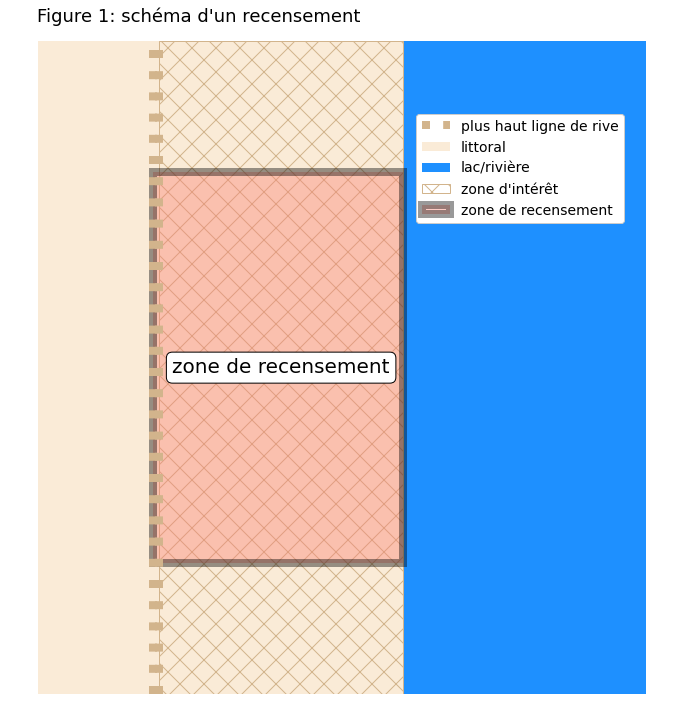

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
figure_num = 1
map_num = 1

plt.axvspan(xmin=0, xmax=1, fc='antiquewhite', label='littoral')
plt.axvspan(xmin=0.6, xmax=1, fc='dodgerblue', label='lac/rivière')
# plt.axvspan(xmin=0.2, xmax=0.5, fc='None', label='debris field')
plt.axvspan(xmin=0.2, xmax=0.6, fc='None', ec='tan', hatch="x", label="zone d'intérêt")
plt.axvspan(xmin=0.19, xmax=0.6, ymin=0.2, ymax=0.8, fc='salmon', alpha=0.4, ec='black', linewidth=8, label='zone de recensement')
plt.axvline(x=0.2, linestyle=":",  c='tan', linewidth=8, label ="plus haut ligne de rive" )
plt.axvline(x=0.19, linestyle=":",  c='tan', linewidth=8 )
ax.annotate("zone de recensement", xy=(0.4, 0.5), xycoords="data",
                  va="center", ha="center", size=20,
                  bbox=dict(boxstyle="round", fc="w"))

make_table_grids(ax)
plt.xticks([])
plt.yticks([])
plt.suptitle(F"Figure {figure_num}: schéma d'un recensement", x=0.16, fontsize=18, y=0.92,ha='left')
plt.legend(fontsize=(14), framealpha=1, bbox_to_anchor=(0.6, .9), loc='upper left')

figname = F"figure{figure_num}.jpg"
atype = "figure"
add_output(figname,  'schematic of a survey', fignum=figure_num, atype=atype)
plt.show()
plt.close()

In [13]:
if is_french:
    sommarkdown = """#### <span style="color:#008891">Scope of surveys</span>\n
    Le champ d'application des enquêtes comprend toutes les berges accessibles sur les lacs mentionnés précédemment dans les conditions suivantes:\n
    
    1. Les transports publics sont à moins d'une demi-heure de marche
    2. Le lieu est un bien public
    3. La zone d'enquête est sûre
    4. Il n'y a pas de contre-indications à la réalisation d'un recensement\n    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Scope of surveys</span>\n
    The scope of the surveys includes all accessible shoreline on the previously mentioned lakes given the following conditions:\n
    
    1. Public transport is 1/2 hour away on foot
    2. The land is open to the public
    3. The location is safe
    4. There is no reason to not do the survey\n    
    """

In [14]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Scope of surveys</span>

    The scope of the surveys includes all accessible shoreline on the previously mentioned lakes given the following conditions:

    
    1. Public transport is 1/2 hour away on foot
    2. The land is open to the public
    3. The location is safe
    4. There is no reason to not do the survey
    
    

In [15]:
if is_french:
    sommarkdown = """### <span style="color:#1e90ff"> Données de synthèse: toutes les enquêtes</span>\n    
    Depuis le 14 avril 2020, 301 échantillons ont été enregistrés, 266 provenant des lacs et 35 de rivières (graphique 1, tableau 1).\n    
    Le nombre d'échantillons dépasse à la fois nos attentes personnelles et les exigences du contrat. Cependant, il reste encore trois mois d'échantillonnage.\n    
    Nous remercions les personnes suivantes pour leur participation:\n
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff"> Summary data: all surveys</span>\n    
    Since april 14, 2020 301 samples have been recorded, 266 from lakes and 35 from rivers (figure 1, table 1).\n 
    The number of samples exceeds both our personal expectations and the contract requirements. However there are still three more months of sampling.\n 
    Thanks to the following individuals for their participation:\n 
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer
    8. Gaetan Buser\n
    
    """

In [16]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff"> Summary data: all surveys</span>
    
    Since april 14, 2020 301 samples have been recorded, 266 from lakes and 35 from rivers (figure 1, table 1).
 
    The number of samples exceeds both our personal expectations and the contract requirements. However there are still three more months of sampling.
 
    Thanks to the following individuals for their participation:
 
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer
    8. Gaetan Buser

    
    

In [17]:
# keep track of the figures you produce

# use all the surveys un aggregated
allsurveys =  newdfx[newdfx.date >= '2020-04-01'].groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).pcs_m.sum()

# identify lakes v/s rivers
allsurveys['type'] = allsurveys.location.map(lambda x: dfBeaches[dfBeaches.index == x]['water'].values[0])

# count the number of rivers and lakes
v_counts = allsurveys['type'].value_counts()
rivercount = int(v_counts['r'])
lakecount = int(v_counts['l'])

# make a table for key statistics:
a_sum = pd.DataFrame(allsurveys.pcs_m.describe()[1:].round(2)).T
a_sum_table = [[x] for x in a_sum.values[0]]
rowLabels = [x for x in list(a_sum.columns)]

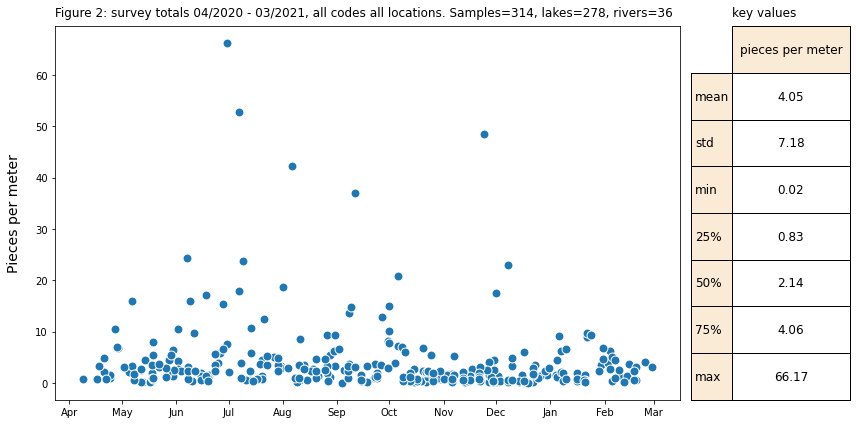

In [18]:
# adjust table kwargs
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), cellLoc='center')

fig = plt.figure(constrained_layout = False, figsize=(12,6))
figure_num += 1

# declare a grid
gs = GridSpec(1, 5, figure=fig)

# put an ax on it
ax1 = fig.add_subplot(gs[4:])

# the context matters for the row and column labels
if is_french:
    rowLabels = summary_row_fr
    col_label = [french_pcm]
else:
    col_label = ['pieces per meter']

# define the table
a_table = mpl.table.table(
    cellText=a_sum_table,
    rowLabels=rowLabels,
    rowColours=['antiquewhite' for i in rowLabels],
    colLabels=['pieces per meter'],
    colColours=['antiquewhite' for col in np.arange(1)],
    
    ax=ax1,
    **tablecenter_k)

def table_format(a_table, ax, size=12):
    table_fonts(a_table, size=size)
    make_table_grids(ax)
    ax.tick_params(**tabtickp_k)

table_format(a_table, ax1) 

# add table to ax
ax1.add_table(a_table )

# scatter plot
ax2 = fig.add_subplot(gs[0:4])
sns.scatterplot(data=allsurveys, x='date',  y='pcs_m', alpha=1, linewidth=1,s=80, ax=ax2)

# format scatter
ax2.xaxis.set_major_formatter(mths_fmt)
ax2.xaxis.set_major_locator(allmonths)
ax2.set_xlabel("")

# context
if is_french:
    ax1.set_title(F"{french_key_values}", loc='left', pad=10)
    ax2.set_title(F"Figure {figure_num}: {french_srs} {startyearmonth} - {endyearmonth}, échantillons={len(allsurveys)}, lacs={lakecount}, rivières={rivercount}.", loc='left', pad=10)
    ax2.set_ylabel(F"{french_pcm}", **ylab_k)
else:
    ax1.set_title(F"key values", loc='left', pad=10)
    ax2.set_ylabel("Pieces per meter", **ylab_k)
    ax2.set_title(F"Figure {figure_num}: survey totals {startyearmonth} - {endyearmonth}, all codes all locations. Samples={len(allsurveys)}, lakes={lakecount}, rivers={rivercount}", loc='left', pad=10)

plt.tight_layout()

# tag the output:
figname = F"figure{figure_num}.jpg"
atype = "figure"
tag =  'all surveys: scatter plot, key values table'
add_output(figname, tag, fignum=figure_num, atype=atype)

plt.show()
plt.close()

In [19]:
if is_french:
    sommarkdown = """#### <span style="color:#008891"> Les objets les plus communs: toutes les enquêtes </span>\n    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Most common objects: all surveys</span>\n    
     """

In [20]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Most common objects: all surveys</span>
    
     

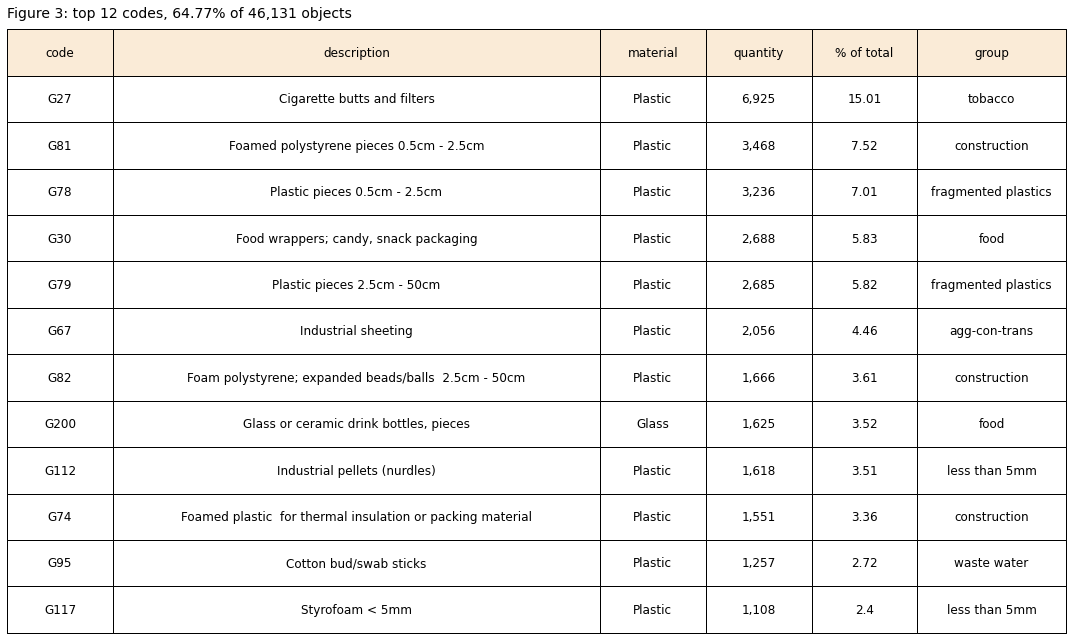

In [21]:
# get the total quantity for each code
allcodevals = pd.DataFrame(newdfx[newdfx.date >= '2020-04-01'].groupby('code').quantity.sum())

# add description and material from the codes df
allcodevals['description'] = allcodevals.index.map(lambda x: dfCodes.loc[x].description)
allcodevals['material'] = allcodevals.index.map(lambda x: dfCodes.loc[x].material)
allcodevals['group'] = allcodevals.index.map(lambda x: a_group_map[x])

# get the total number of objects and the percent of total
allcodevalst= allcodevals.quantity.sum()
allcodevals['p_total'] = allcodevals.quantity/allcodevalst*100
allcodevals['p_total'] = allcodevals['p_total'].round(2)

# sort the values 
allcodevals = allcodevals.sort_values(by='quantity',ascending=False)

# do some housekeeping
allcodevals.rename(columns={'p_total':'% of total'}, inplace=True)
allcodevals = allcodevals[['description', 'material', 'quantity', '% of total', 'group']]

# format for charting
allcodevals.reset_index(inplace=True)
allcodevals['quantity'] = allcodevals.quantity.apply(lambda x: "{:,}".format(x))

# define the most common objects:
tabledata = allcodevals[allcodevals['% of total'] >= 2]

# sum the % of total of the most common objects
ptotal = tabledata['% of total'].sum()
# is_french = True
if is_french:
    tabledatacopy = tabledata.copy()
    tabledatacopy['description'] = tabledatacopy.code.map(lambda x: count_k(fr_defs_codes[x], limit))
    tabledatacopy['group'] = tabledatacopy.group.map(lambda x: count_k(french_names[x], limit))
    tabledatacopy.rename(columns=french_columns, inplace=True)
    tabledata = tabledatacopy

# make adjustments to table kwargs:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[10,46, 10, 10, 10,14], cellLoc='center')

# plot the table:
fig, ax = plt.subplots(figsize=(15, len(tabledata)*.75))
figure_num += 1
ax = make_table_grids(ax)
a_table = mpl.table.table(
    cellText=tabledata.values,
    colLabels=tabledata.columns,
    colColours=['antiquewhite' for col in list(tabledata.columns)],    
    ax=ax,
    **tablecenter_k)

# set parameters
table_fonts(a_table, size=12)
ax.tick_params(**tabtickp_k)

# add the table
ax.add_table(a_table)


if is_french:
    ax.set_title(F"Figure {figure_num}: top {len(tabledata)} codes, {np.round(ptotal, 2)}% de {'{:,}'.format(allcodevalst)} objets", **title_k14)
else:
    ax.set_title(F"Figure {figure_num}: top {len(tabledata)} codes, {np.round(ptotal, 2)}% of {'{:,}'.format(allcodevalst)} objects", **title_k14)


plt.tight_layout()
figname = F"figure{figure_num}.jpg"
tag = 'all surveys: most common objects table'
add_output(figname, tag, fignum=figure_num)
plt.show()
plt.close()

In [22]:
if is_french:
    sommarkdown = """### <span style="color:#1e90ff"> Données de synthèse sur les lacs du projet </span>\n
    
    Il y a 8 lacs concernés par le projet:\n

    1. Zurichsee
    2. Lago Maggiore
    3. Thunersee
    4. Lac Léman
    5. Bielersee
    6. Lac de Neuchâtel
    7. Walensee
    8. Brienzersee\n

    Le lac de Brienze a été ajouté à la liste des lacs étudiés, en raison de sa position dans le bassin versant de l'Aare (graphique 2, tableau 3).
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff"> Project lakes summary data </span>\n
    
    There are eight project lakes:\n

    1. Zurichsee
    2. Lago Maggiore
    3. Thunersee
    4. Lac Léman
    5. Bielersee
    6. Neuenburgersee
    7. Walensee
    8. Brienzersee\n

    Brienzersee was added to the surveys beacuase of it's position in the catchment area of the Aare (figure 2, table 3).
    
    """
    

In [23]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff"> Project lakes summary data </span>

    
    There are eight project lakes:


    1. Zurichsee
    2. Lago Maggiore
    3. Thunersee
    4. Lac Léman
    5. Bielersee
    6. Neuenburgersee
    7. Walensee
    8. Brienzersee


    Brienzersee was added to the surveys beacuase of it's position in the catchment area of the Aare (figure 2, table 3).
    
    

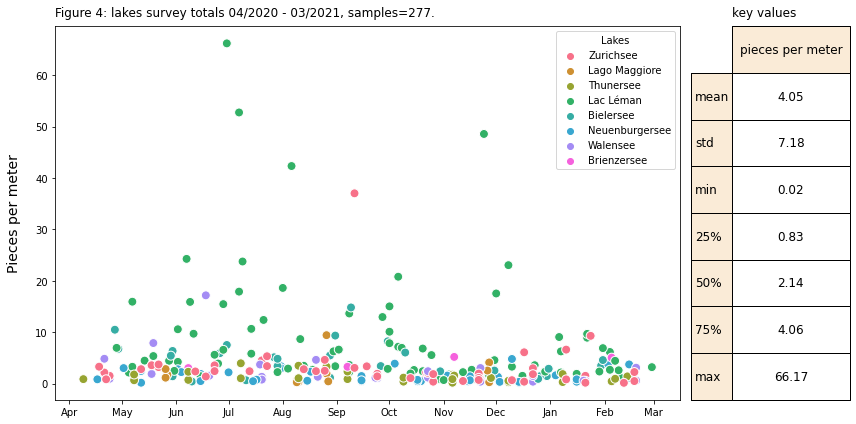

In [24]:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), cellLoc='center')

fig = plt.figure(constrained_layout = False, figsize=(12,6))
figure_num += 1

ax1 = fig.add_subplot(gs[4:])

if is_french:
    rowLabels = summary_row_fr
    col_label = [french_pcm]
else:
    col_label = ['pieces per meter']

a_table = mpl.table.table(
    cellText=a_sum_table,
    rowLabels=rowLabels,
    rowColours=['antiquewhite' for i in rowLabels],
    colLabels=col_label,
    colColours=['antiquewhite' for col in np.arange(1)],
    
    ax=ax1,
    **tablecenter_k)


table_format(a_table, ax1) 
ax1.add_table(a_table )

if is_french:
    ax1.set_title(F"{french_key_values}", loc='left', pad=10)
else:
    ax1.set_title(F"key values", loc='left', pad=10)
    

ax2 = fig.add_subplot(gs[0:4])
sns.scatterplot(data=somdata, x='date',  y='pcs_m', hue='water_name', palette='husl', alpha=1, linewidth=1,s=80, ax=ax2)
ax2.xaxis.set_major_formatter(mths_fmt)
ax2.xaxis.set_major_locator(allmonths)
ax2.set_ylabel("Pieces per meter", **ylab_k)

if is_french:
    ax2.set_title(F"Figure {figure_num}: {french_srs} {startyearmonth} - {endyearmonth}, échantillons={len(somdata)}.", loc='left', pad=10)
    ax2.set_ylabel(F"{french_pcm}", **ylab_k)
    
else:
    ax2.set_title(F"Figure {figure_num}: lakes survey totals {startyearmonth} - {endyearmonth}, samples={len(somdata)}.", loc='left', pad=10)
ax2.set_xlabel("")
ax2.legend(title="Lakes")



fignum = figure_num
plt.tight_layout()
figname = F"figure{figure_num}.jpg"
atype='figure'
tag =  'lake surveys: scatter plot, key values table'
add_output(figname, tag, fignum=fignum, atype=atype)

plt.show()

In [25]:
if is_french:
    sommarkdown = """#### <span style="color:#008891"> Les objets les plus communs: les lacs du projet</span>\n
    """
else:
    sommarkdown = """#### <span style="color:#008891">Most common objects: project lakes</span>\n
    """

In [26]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Most common objects: project lakes</span>

    

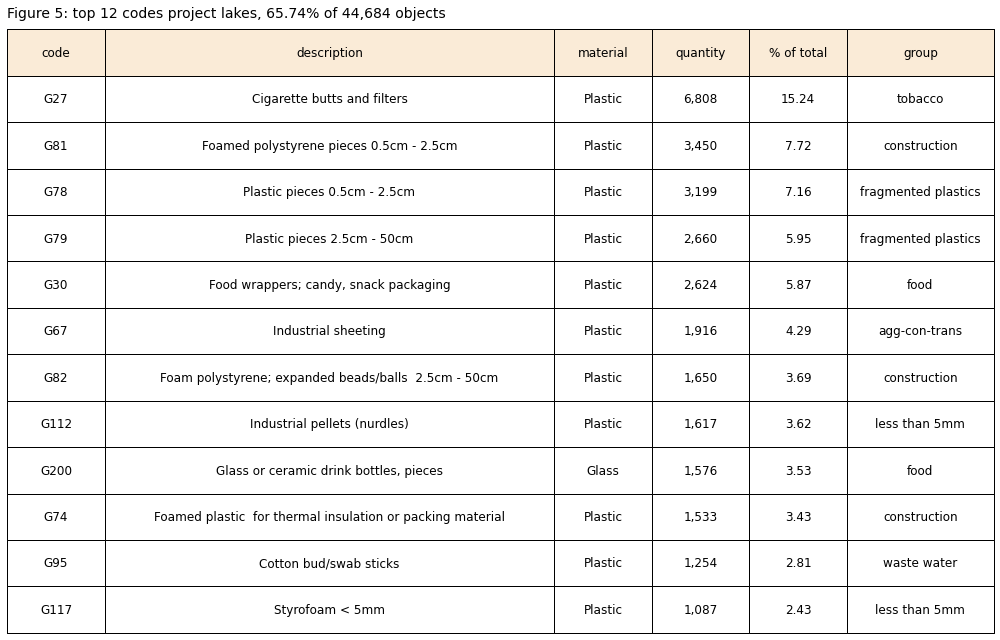

In [27]:
allcodevals = pd.DataFrame(useThis.groupby('code').quantity.sum())

# add description and material from the codes df
allcodevals['description'] = allcodevals.index.map(lambda x: dfCodes.loc[x].description)
allcodevals['material'] = allcodevals.index.map(lambda x: dfCodes.loc[x].material)
allcodevals['group'] = allcodevals.index.map(lambda x: a_group_map[x])

# get the total number of objects and the percent of total
allcodevalst= allcodevals.quantity.sum()
allcodevals['p_total'] = allcodevals.quantity/allcodevalst*100
allcodevals['p_total'] = allcodevals['p_total'].round(2)

# ptotal = allcodevals['p_total'].sum()

# sort the values 
allcodevals = allcodevals.sort_values(by='quantity',ascending=False)

# do some housekeeping
allcodevals.rename(columns={'p_total':'% of total'}, inplace=True)
allcodevals = allcodevals[['description', 'material', 'quantity', '% of total', 'group']]

# format for charting
allcodevals.reset_index(inplace=True)
allcodevals['quantity'] = allcodevals.quantity.apply(lambda x: "{:,}".format(x))

# define the most common objects:
tabledata = allcodevals[allcodevals['% of total'] >= 2]

# sum the % of total of the most common objects
ptotal = tabledata['% of total'].sum()

# check context
if is_french:
    tabledatacopy = tabledata.copy()
    tabledatacopy['description'] = tabledatacopy.code.map(lambda x: count_k(fr_defs_codes[x], limit))
    tabledatacopy['group'] = tabledatacopy.group.map(lambda x: count_k(french_names[x], limit))
    tabledatacopy.rename(columns=french_columns, inplace=True)
    tabledata = tabledatacopy

# make adjustments to table kwargs:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[10,46, 10, 10, 10,15], cellLoc='center')

# plot the table:
fig, ax = plt.subplots(figsize=(14, len(tabledata)*.75))
figure_num += 1
ax = make_table_grids(ax)
a_table = mpl.table.table(
    cellText=tabledata.values,
    colLabels=tabledata.columns,
    colColours=['antiquewhite' for col in list(tabledata.columns)],    
    ax=ax,
    **tablecenter_k)

table_fonts(a_table, size=12)

ax.add_table(a_table)
ax.tick_params(**tabtickp_k)

# check context

if is_french:
    ax.set_title(F"Figure {figure_num}: top {len(tabledata)} codes des lacs du projet, {np.round(ptotal, 2)}% de {'{:,}'.format(allcodevalst)} objets", **title_k14)
    
else:
    ax.set_title(F"Figure {figure_num}: top {len(tabledata)} codes project lakes, {np.round(ptotal, 2)}% of {'{:,}'.format(allcodevalst)} objects", **title_k14)

figname = F"figure{figure_num}.jpg"
fignum=figure_num
tag = 'lake surveys: most common objects table'


plt.tight_layout()
add_output(figname,tag , fignum=fignum)
plt.show()
plt.close()

In [28]:
if is_french:
    sommarkdown = """### <span style="color:#1e90ff"> Lacs du projet : objets regroupés par usage ou caractéristiques physiques</span>\n
    """
else:
    sommarkdown = """### <span style="color:#1e90ff"> Project lakes: objects grouped by use or physical characteristics</span>\n
    """

In [29]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff"> Project lakes: objects grouped by use or physical characteristics</span>

    

In [30]:
atotal = useThis.quantity.sum()
groupoftotal = useThis.groupby('groupname', as_index=False).quantity.sum()
groupoftotal['p_total'] = (groupoftotal.quantity/atotal)*100
groupoftotal['p_total'] = groupoftotal['p_total'].round(2)
groupoftotal.sort_values(by='p_total', ascending=True, inplace=True)
anorder = groupoftotal.groupname.values

In [31]:
boxes = useThis.groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()
get_an_order = boxes.groupby('groupname').pcs_m.median()
an_order_of_boxes = get_an_order.sort_values(ascending=True)
a_box_order = an_order_of_boxes.index

In [32]:
# get the significant value for each code group
sig_vals = boxes.groupby('groupname').pcs_m.quantile(sig)

# map the significant value to the results
boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# create a boolean for significant
boxes['significant'] = boxes.pcs_m >= boxes.limit

# map to number of samples, and significant values
survey_totals.reset_index(inplace=True)

# number of samples per lake
tries = survey_totals.groupby(['water_name']).loc_date.nunique()

# number of locations per lake
num_locations = useThis.groupby('water_name').location.nunique()

# fails: number of locations where object group has been identified
num_with = useThis[useThis.quantity > 0].groupby(['water_name', 'groupname']).location.nunique()

# fails: number of samples with the object group
samps_with = useThis[useThis.quantity > 0].groupby(['water_name', 'groupname']).loc_date.nunique()

# median pcs_m
median_pcs = boxes[boxes.pcs_m >0].groupby(['water_name', 'groupname']).pcs_m.median()

# mean pcs_m
mean_pcs = boxes[boxes.pcs_m >0].groupby(['water_name', 'groupname']).pcs_m.mean()

# significant values
# determine wether or not the event was greater than the 90th percentile

# map limit to data
boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# create boolean
boxes['significant'] = boxes.pcs_m >= boxes.limit

# make a df of tests and test failures
fails = boxes.groupby(['water_name', 'groupname'], as_index=False).significant.sum()

# get the number of samples for the lake
fails['samples'] = fails.water_name.map(lambda x: tries[x])

# display the ratio of significant values to samples
fails['frequency_s'] = fails.significant.astype('str') + '/' + fails.samples.astype('str')

# the number of locations
fails['locations'] = fails.water_name.map(lambda x: num_locations[x])

def locations_with(x,y,somdata):
    try:
        has = somdata[x][y]        
    except:
        has = 0
    return has
        
# the number of locations where the object group has been identified
fails['loc_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], num_with), axis=1)

# the number of samples where the object group has been identified
fails['samp_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], samps_with), axis=1)

# samples frequency of failure
fails['frequency'] = fails.samp_with.astype('str') + '/' + fails.samples.astype('str')

# locations frequency of failure
fails['frequency_l'] = fails.loc_with.astype('str') + '/' + fails.locations.astype('str')

# median/mean pcs_m:
fails['median pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], median_pcs), axis=1)
fails['mean pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], mean_pcs), axis=1)

# likelihood
fails['likelihood'] = ((fails.loc_with/fails.locations)*(fails.samp_with/fails.samples))*100
fails['likelihood'] = fails.likelihood.astype('int')

table_data = fails[['water_name','frequency_l', 'frequency',  'frequency_s', 'likelihood','median pcs/m', 'groupname']].copy()
table_data.rename(columns={'water_name':'name', 'frequency_l':"# locations", 'frequency':"# samples", 'frequency_s':'# significant'}, inplace=True)

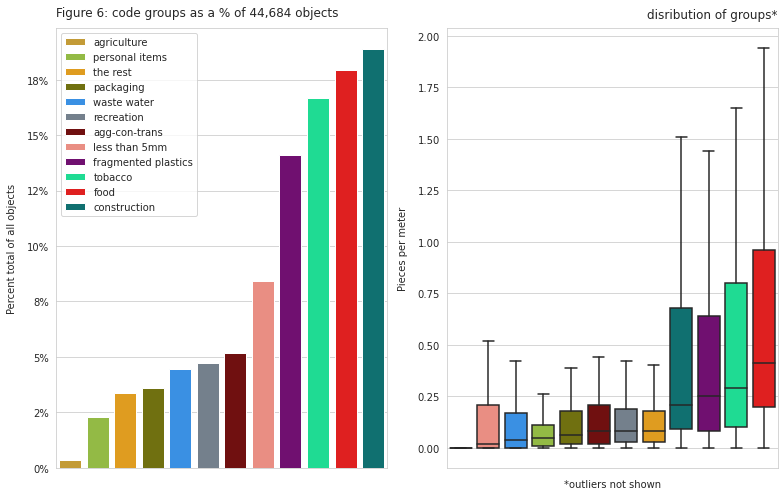

In [33]:
sns.set_style('whitegrid')
markers = ['s', 'P', 'D', 'X', 'o']
def make_ecdf(somdata, numsamps):
    vals = somdata.pcs_m.sort_values()
    valsy = [i/numsamps for i in np.arange(numsamps)]
    return vals, valsy
a_form = mtick.FormatStrFormatter('%.0f%%')


fig, ax = plt.subplots(1,2, figsize=(11, 7))
figure_num += 1
if is_french:
    groupoftotal['groupname'] = groupoftotal['groupname'].map(lambda x: french_names[x])
    groupdconcat['groupname'] = groupdconcat['groupname'].map(lambda x: french_names[x])
    anorder = [french_names[x] for x in a_box_order]

    sns.barplot(data=groupoftotal, x='groupname', hue='groupname', palette=frpalette, y='p_total', dodge=False, ax=ax[0])
    ax[0].set_ylabel(F"{french_pct}", labelpad=10)
    ax[0].set_title(F"Figure {figure_num}: {french_bg} % {of_prep} {'{:,}'.format(atotal)} {thing}", **title_k)
    ax[0].set_xlabel("")
    ax[0].set_xticklabels("")
    ax[0].legend(loc='upper left')    
    
    sns.boxplot(data=useThis[['groupname','pca_m']], x='groupname', y='pcs_m', hue='groupname', order=anorder, palette=frpalette, dodge=False, ax=ax[1],  showfliers=False)
    ax[1].set_ylabel(F"{french_pcm}", labelpad=10)
    ax[1].set_title(F"distribution {french_bg}*", **titler_k)
    ax[1].set_xlabel(F"{french_nooutliers}")
    ax[1].get_legend().remove()
    ax[1].set_xticklabels("")
    

else:
    sns.barplot(data=groupoftotal, x='groupname', hue='groupname', palette=grouppalette, y='p_total', dodge=False, ax=ax[0])
    ax[0].set_ylabel("Percent total of all objects", labelpad=10)
    ax[0].set_title(F"Figure {figure_num}: code groups as a % of {'{:,}'.format(atotal)} objects", **title_k)
    ax[0].yaxis.set_major_formatter(a_form)
    ax[0].set_xlabel("")
    ax[0].set_xticklabels("")
    ax[0].legend(loc='upper left')    
    
    sns.boxplot(data=boxes[['groupname','pcs_m']], x='groupname', y='pcs_m', hue='groupname', palette=grouppalette, order=a_box_order, dodge=False, ax=ax[1], showfliers=False)
    ax[1].set_ylabel("Pieces per meter", labelpad=10)
    ax[1].set_title(F"disribution of groups*", **titler_k)
    ax[1].set_xlabel("*outliers not shown")
    ax[1].get_legend().remove()
    ax[1].set_xticklabels("")
    
fignum=figure_num
    
plt.tight_layout()
figname = F"figure{fignum}.jpg"
atype='figure'
tag = 'code groups: percentage of total, distribution'
add_output(figname, tag, fignum=fignum, atype=atype)
plt.show()
plt.close()

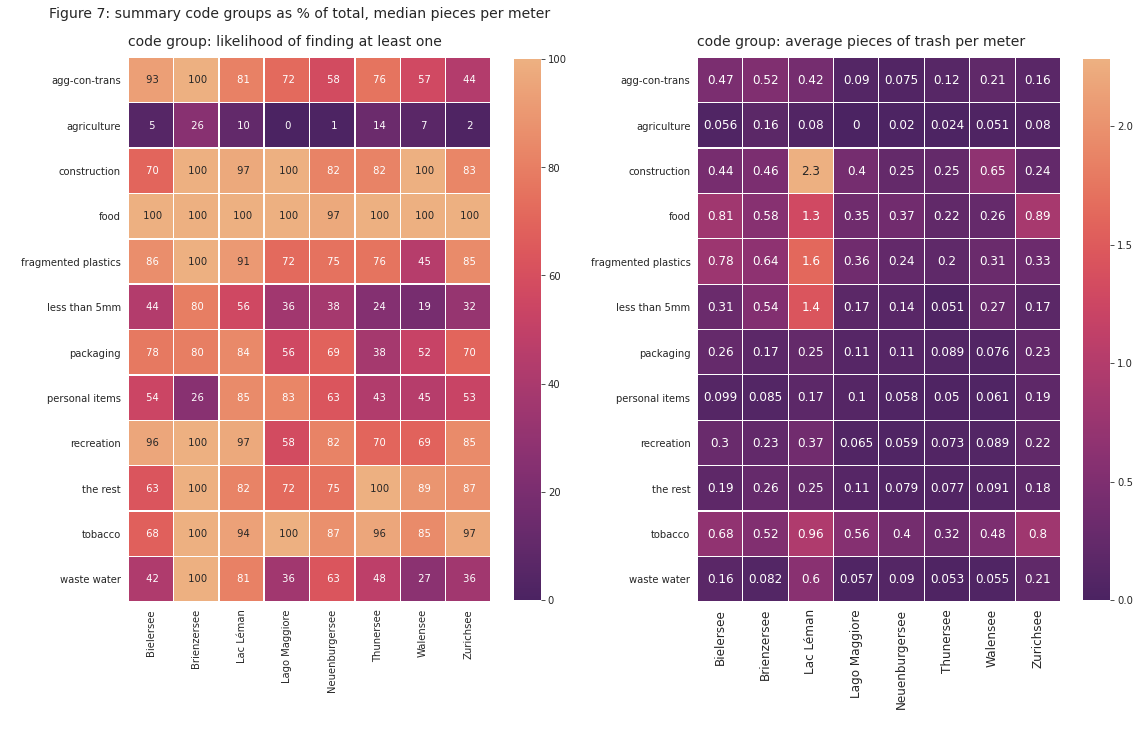

In [34]:
if is_french:
    sigheat['groupname'] = sigheat.groupname.map(lambda x: french_names[x])
    sigdf['groupname'] = sigdf.groupname.map(lambda x: french_names[x])

fig,axx = plt.subplots(1,2, figsize=(16,10))
figure_num += 1
# heat_map_palette = sns.color_palette("light:darkred", as_cmap=True)
heat_map_palette = 'flare_r'
linecolor = 'white'

sns.heatmap(
    fails[['water_name', 'groupname', 'likelihood']].pivot(columns='water_name', index='groupname'),
    cmap=heat_map_palette, ax=axx[0],
    square=True, cbar_kws={"shrink": .9},
    annot=True, fmt=" ", linewidths=.5, linecolor=linecolor)
labels = [a_text.get_text() for a_text in axx[0].get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[len('likelihood')+1:]
    newlabels.append(newlabel)
axx[0].set_xticklabels(newlabels)

axx[0].set_ylabel(" ")
axx[0].set_xlabel(" ")
ax[0].tick_params(axis='both', labelsize=12)
if is_french:
    axx[0].set_title(F"groupe de codes probabilité de trouver au moins une", **title_k14)
else:
    axx[0].set_title(F"code group: likelihood of finding at least one", **title_k14)

sns.heatmap(fails[['water_name', 'groupname', 'mean pcs/m']].pivot(columns='water_name', index='groupname'), cmap=heat_map_palette, ax=axx[1], square=True, cbar_kws={"shrink": .9}, annot=True, annot_kws={'fontsize':12},linewidths=.1, linecolor=linecolor)
axx[1].set_xticklabels(newlabels, fontsize=12)
axx[1].set_ylabel(" ")
axx[1].set_xlabel(" ")
ax[1].tick_params(axis='both', labelsize=12)

if is_french:
    axx[1].set_title(F"la valeur moyenne de déchets par mètre", **title_k14)
    plt.suptitle(F"Figure {figure_num}: tous les lacs, pourcentage des échantillons > 90%, la valeur médiane de déchets par mètre", ha='left', size=14, x=0.06, y=1)
else:
    axx[1].set_title(F"code group: average pieces of trash per meter", **title_k14)
    plt.suptitle(F"Figure {figure_num}: summary code groups as % of total, median pieces per meter", ha='left', size=14, x=0.04, y=1)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
atype="figure"
figname = F"figure{figure_num}.jpg"
tag = F"likelihood of finding one object from a group and median pcs/m"
add_output(figname,tag, fignum=figure_num, atype=atype)

plt.show()
plt.close()

In [35]:
tries_l = boxes.groupby('location').loc_date.nunique()
fails_l = boxes[boxes.pcs_m > 0].groupby(['location', 'groupname']).loc_date.nunique()
lake_l = fails.set_index(['groupname','water_name'])
lake_l = lake_l['likelihood']

fails_beach = boxes.groupby(['location', 'water_name','groupname'], as_index=False).pcs_m.median()
fails_beach['tries'] = fails_beach.location.map(lambda x: tries_l[x])
fails_beach['fails'] = fails_beach.apply(lambda x:locations_with(x['location'], x['groupname'], fails_l), axis=1)
fails_beach['loclikelihood'] = (fails_beach.fails/fails_beach.tries) * 100
fails_beach['loclikelihood'] = fails_beach['loclikelihood'].astype('int')
fails_beach['lakelikelihood'] = fails_beach.apply(lambda x:locations_with(x['groupname'], x['water_name'], lake_l), axis=1)
fails_beach['likelihood'] = (fails_beach.loclikelihood*fails_beach.lakelikelihood)/100
fails_beach['likelihood'] = fails_beach['likelihood'].astype('int')

a = boxes.groupby('location').significant.sum()
these_beaches['significant'] = these_beaches.index.map(lambda x: a.loc[x])
these_beaches.to_csv(F"{project_directory}/these_beaches.csv")
these_rivers = dfSurveys[(dfSurveys.date >= start_date)]['location'].unique()
river_beaches = dfBeaches.loc[(dfBeaches.index.isin(these_rivers))&(dfBeaches.water == 'r')]
river_beaches.to_csv(F"{project_directory}/these_rivers.csv")

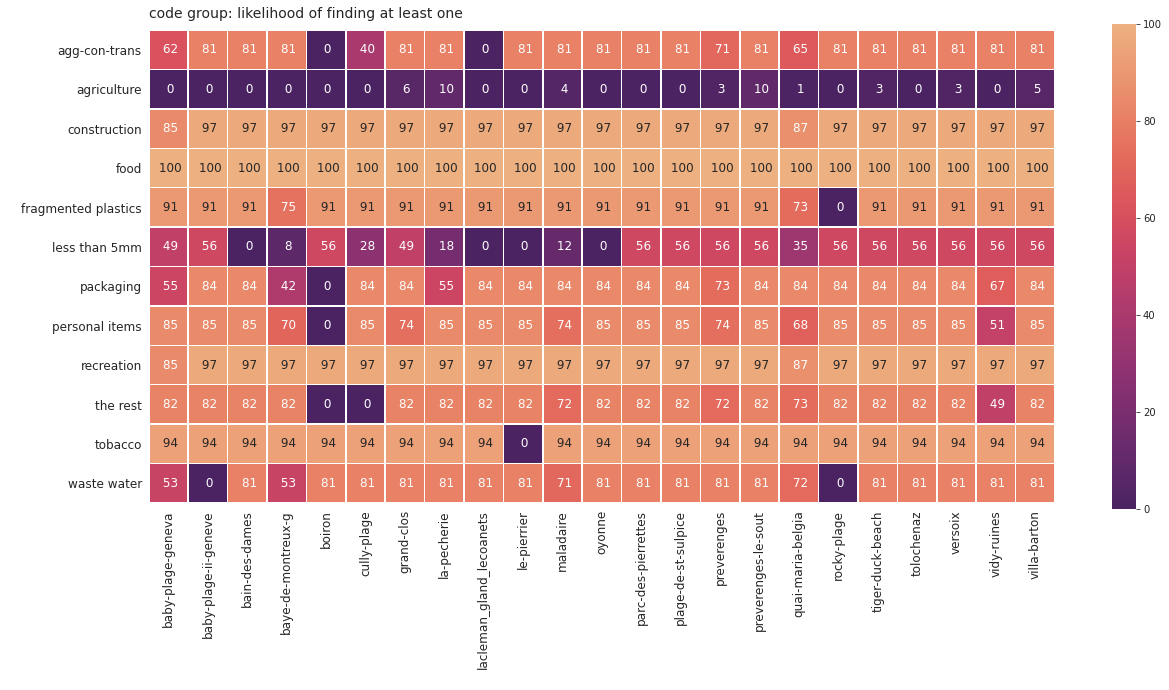

In [36]:
fig,axx = plt.subplots(figsize=(18,18))
figure_num += 1

this_data=fails_beach[fails_beach.water_name == lake].copy()

sns.heatmap(
    this_data[['location', 'groupname', 'likelihood']].pivot(columns='location', index='groupname'), 
    cmap=heat_map_palette,
    linecolor=linecolor,
    ax=axx, 
    square=True, 
    annot=True,
    cbar_kws={"shrink": .38}, 
    annot_kws={'fontsize':12}, 
    linewidths=.5,
    fmt=" ",
)
labels = [a_text.get_text() for a_text in axx.get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[len('likelihood')+1:]
    newlabels.append(newlabel)

axx.set_xticklabels(newlabels)

axx.set_ylabel(" ")
axx.set_xlabel(" ")
axx.tick_params(axis='both', labelsize=12)

if is_french:
    axx.set_title(F"code group: likelihood of finding at least one", **title_k14)
else:
    axx.set_title(F"code group: likelihood of finding at least one", **title_k14)


plt.tight_layout()
atype="figure"
figname = F"figure{figure_num}.jpg"
tag = F"{lake} code groups percent of total by location."
add_output(figname,tag, fignum=figure_num, atype=atype)

plt.show()

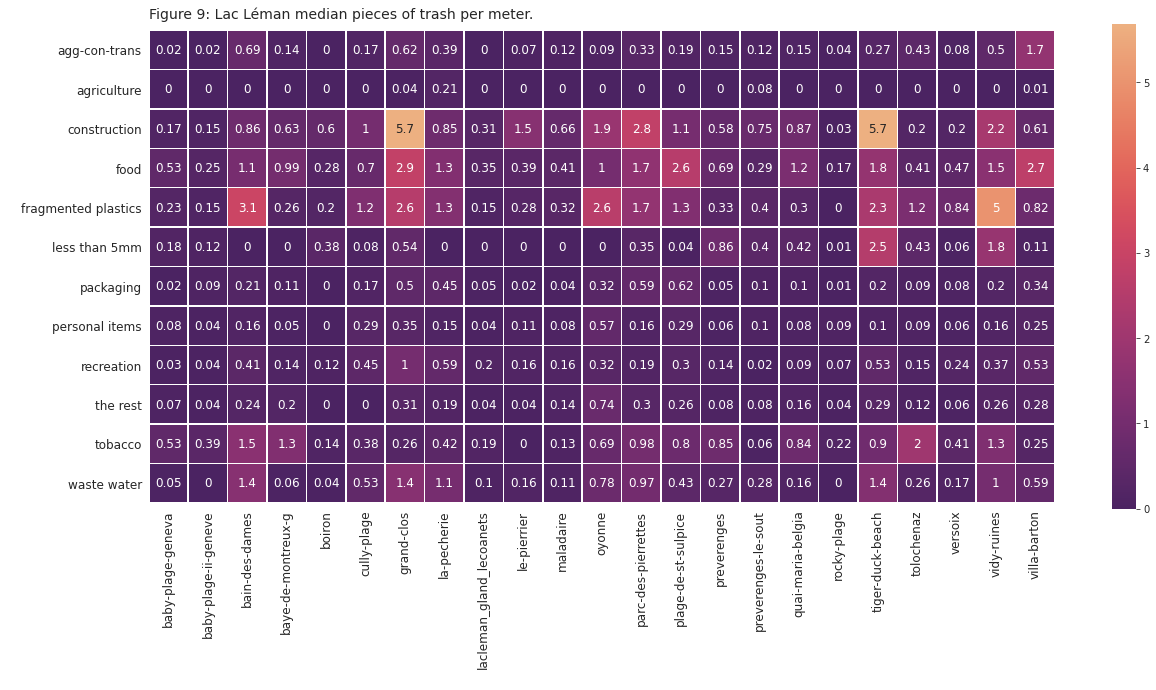

In [37]:
fig,axx = plt.subplots(figsize=(18,18))
figure_num += 1

sns.heatmap(this_data[['location', 'groupname', 'pcs_m']].pivot(columns='location', index='groupname'),
            cmap=heat_map_palette, ax=axx, square=True, annot=True,cbar_kws={"shrink": .38}, annot_kws={'fontsize':12}, linewidths=.5, linecolor=linecolor)
labels = [a_text.get_text() for a_text in axx.get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[6:]
    newlabels.append(newlabel)
axx.set_xticklabels(newlabels, fontsize=12)
axx.set_ylabel(" ")
axx.set_xlabel(" ")
axx.tick_params(axis='both', labelsize=12)

if is_french:
    axx.set_title(F"Figure {figure_num}: {lake} la valeur médiane de déchets par mètre.", **title_k14)
else:
    axx.set_title(F"Figure {figure_num}: {lake} median pieces of trash per meter.", **title_k14)
    
plt.tight_layout()
atype="figure"
figname = F"figure{figure_num}.jpg"
tag = F"{lake} all locations median pcs/m"
add_output(figname,tag, fignum=figure_num, atype=atype)
plt.show()

In [38]:
if is_french:
    sommarkdown = """#### <span style="color:#008891">Commentaire groupe d'objets</span>
    Les restes représente la plus grande proportion des objets trouvés. Cela illustre l'importance du transport fluvial et les difficultés liées à la détermination de la source géographique exacte de la plupart des objets.

    Lorsqu'ils sont combinés, les groupes de l'agriculture, de la construction et l'agriculture ou de construction et agriculture représentent ~26%, soit à peu près le même que celui des kiosques.
    
    Le groupe des microplastiques représente ~ 8% du total. Il faut tenir compte du fait que ces objets, par définition, sont difficiles à voir et qu'ils sont donc certainement sous-représentés dans ces chiffres.    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Comments object groups</span>

    The rest represents the biggest proportion of the objects found. This illustrates the importance of fluvial transport and the difficulties associated with determining the exact geographic source of most objects.
    
    When combined, the groups of aggriculture, construction and agg or construction are ~26% or about the same as the kiosk group.
    
    The microplastic group is ~ 8% of the total. These objects, by definition, are difficult to see and therfore are certainly under represented in these counts.
    """ 


### <span style="color:#1e90ff"> Group components</span>

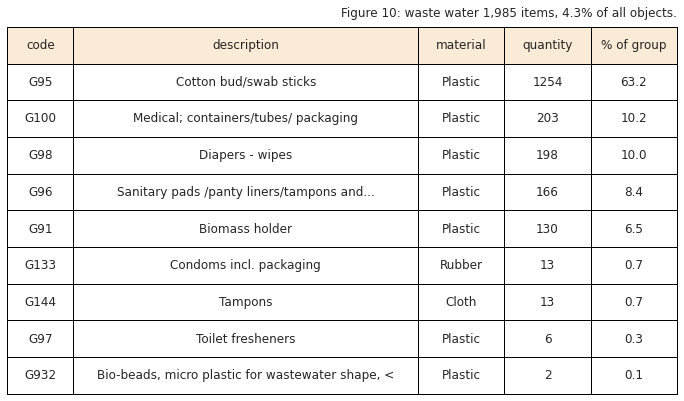

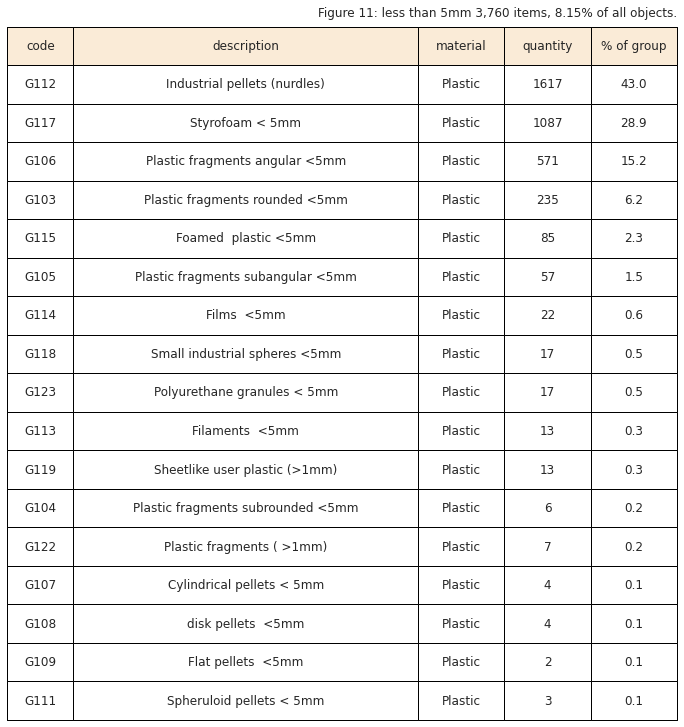

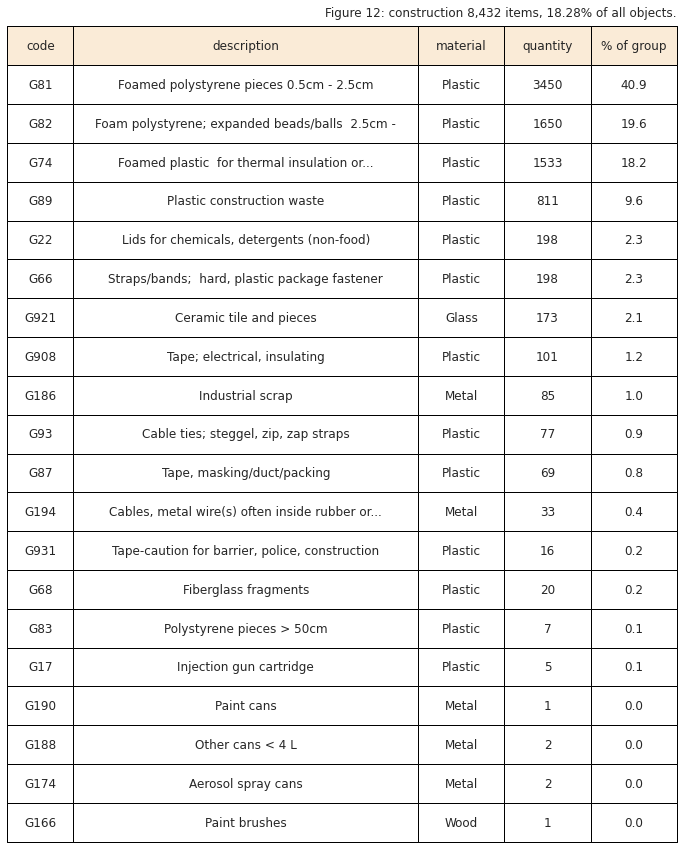

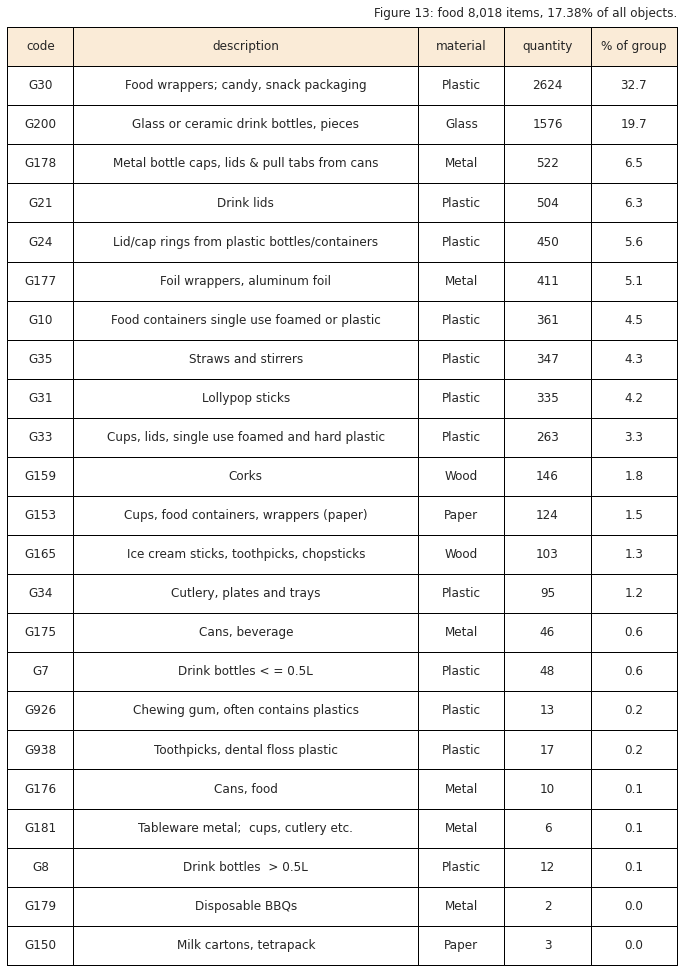

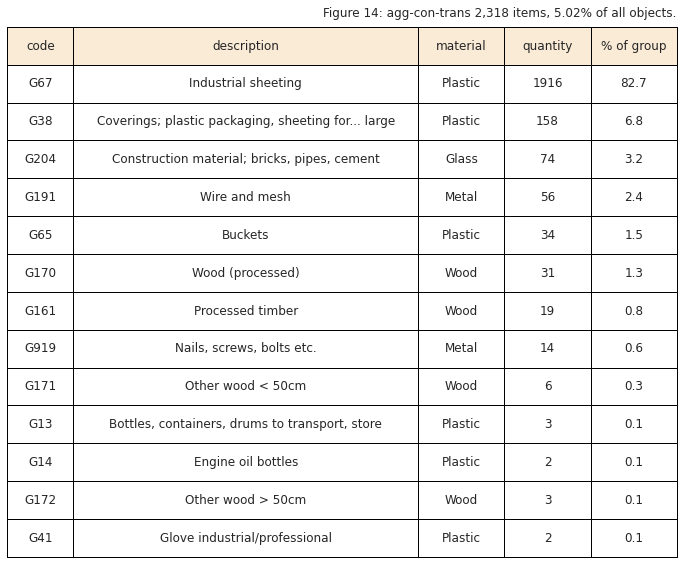

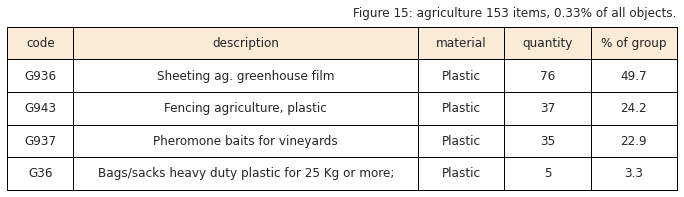

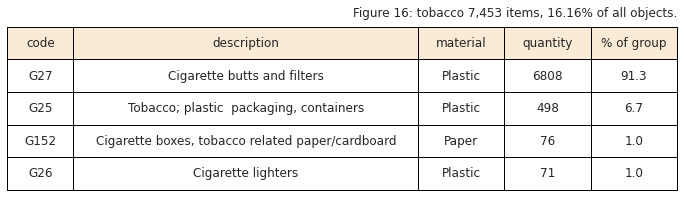

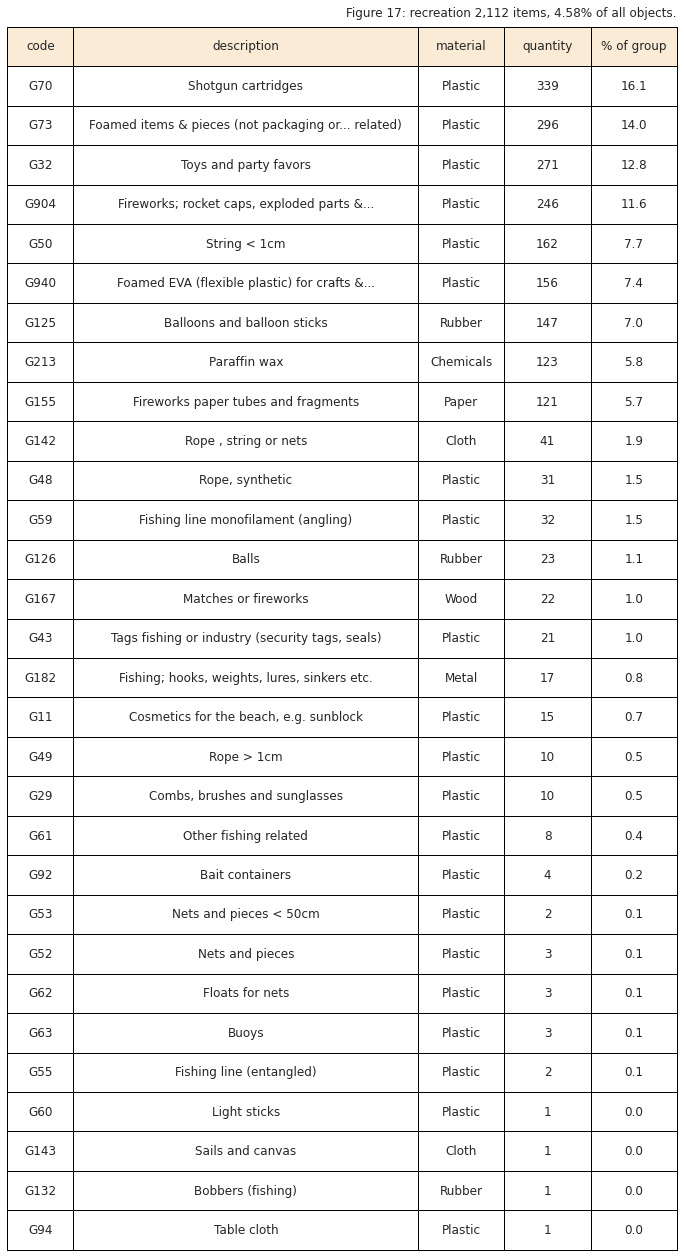

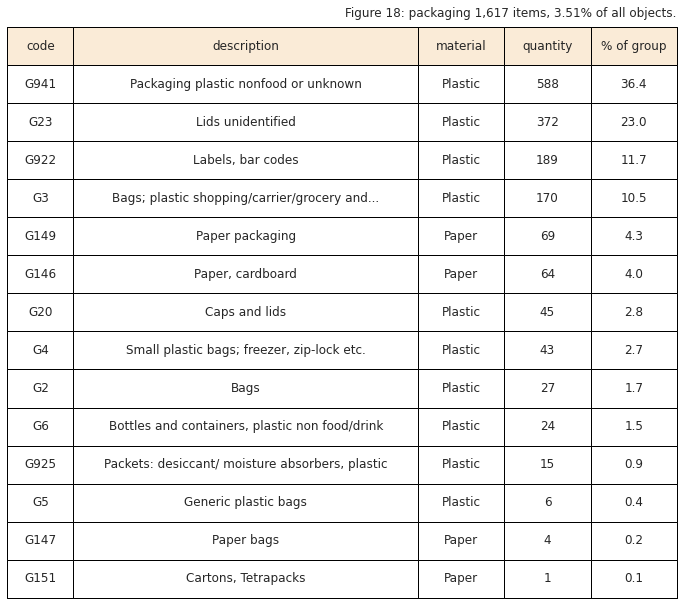

In [ ]:
is_french = False
# creating tables for each code group
# each table is saved in jpeg


# context:
french_columns = {'code':'code','description': 'description', 'material':'matériel', 'quantity':'quantité'}
thing = 'objets'
parent = "de l'ensemble"

# define the summary table for each code group
groupTotals = {}
for name in group_names:
    
    somdata = useThis[useThis.groupname == name ].copy()
    somdata = somdata[somdata.quantity > 0]
    newdata = somdata.groupby('code').agg({'quantity':'sum', 'pcs_m':'mean'})
    somdatatot = somdata.quantity.sum()
    newdata['% of group']=np.round((newdata.quantity/somdatatot)*100, 1)
    # check context
    if is_french:
        newdata['description'] = newdata.index.map(lambda x: count_k(fr_defs_codes[x], limit))
    else:
        # do it in english
        newdata['description'] = newdata.index.map(lambda x: count_k(dfCodes.loc[x].description, limit))
        
    newdata['material'] = newdata.index.map(lambda x: dfCodes.loc[x].material)
    newdata.reset_index(inplace=True)
    
    newdata.drop('pcs_m', axis=1, inplace=True)
    newdata = newdata[['code','description', 'material', 'quantity', '% of group']]
    newdata.sort_values(by='% of group', ascending=False, inplace=True)
    groupTotals.update({name:newdata})


tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[10,52, 13, 13, 13], cellLoc='center')
a_total = newdfx.quantity.sum()

for i,name in enumerate(group_names):
    # make the data
    somdata = groupTotals[name]
    
    # get the number of records
    somnums = np.arange(len(somdata))
    
    # get the total for the group
    group_total = somdata.quantity.sum()
    
    # check context before exporting:
    if is_french:
        # makes the column headers to desired language:
        somdata.rename(columns=french_columns, inplace=True)
    
    # make the figure
    fig, axs = plt.subplots(figsize=(12, len(somdata)*.75))
    # keep track
    figure_num += 1
    
    # define table
    a_table = mpl.table.table(
        cellText=somdata.values,
        colLabels=list(somdata.columns),
        colColours=['antiquewhite' for i in list(somdata.columns)],
        
        ax=axs,
        **tablecenter_k)
    
    # add table to figure and set parameters
    axs.add_table(a_table)
    table_fonts(a_table, size=12)
    make_table_grids(axs)
    axs.tick_params(**tabtickp_k)    
    
    # check context, the name is used to iterate so:    
    if is_french:
        axs.set_title(F"Figure {figure_num}: {french_names[name]} {'{:,}'.format(group_total)} {thing}, {np.round((group_total/a_total)*100, 2)}% {parent}.", **titler_k)
    else:
        # do it in english
        axs.set_title(F"Figure {figure_num}: {name} {'{:,}'.format(group_total)} items, {np.round((group_total/a_total)*100, 2)}% of all objects.", **titler_k)
    # tag and save
    figname = F"figure{figure_num}.jpg"
    tag = F"{name} component codes"
    
    add_output(figname, tag, fignum=figure_num)
    
    plt.show()
    plt.close()
        

In [ ]:
is_french = False
if is_french:
    sommarkdown = """### <span style="color:#1e90ff">Résultats par groupe de codes</span>\n#### <span style="color:#008891">résultats mensuels médians</span>\n
    """

else:
    sommarkdown = """### <span style="color:#1e90ff">Survey results per code group</span>\n#### <span style="color:#008891">Median monthly survey results</span>\n
    """

In [ ]:
display(Markdown(sommarkdown))

In [ ]:
boxes.set_index('date', inplace=True)

In [ ]:
monthly = pd.DataFrame(boxes.groupby('groupname').resample('M').pcs_m.median())
monthly['change'] = monthly.pcs_m.diff().round(4)
monthly.fillna(0, inplace=True)
monthly.reset_index(inplace=True)

In [ ]:
french_columns = {'code':'code','description': 'description', 'material':'matériel', 'quantity':'quantité'}
thing = 'objets'
parent = "de l'ensemble"
french_pcm = "pièces par mètre"
french_srs = "résultats des recensements"
french_pcg = "par groupe de codes"
french_med = "médian"
french_mm = "médiane mensuelle"
french_change = 'changement'

fig, axs = plt.subplots(3,1,figsize=(14,16))
figure_num +=1

# plots
sns.scatterplot(data=boxes, x='date',  y='pcs_m', hue='groupname', palette=grouppalette, alpha=0.8,s=60, ax=axs[0])
sns.lineplot(data=monthly, x='date', y='pcs_m', hue='groupname', palette=grouppalette, ax=axs[1])
sns.lineplot(data=monthly, x='date',  y='change',  hue='groupname', palette=grouppalette, linewidth=2, ax=axs[2])

if is_french:    
    # titles
    axs[0].set_title(F"Figure {figure_num}:{french_srs} {french_pcg}, {startyearmonth} - {endyearmonth}, n={len(boxes)}", **title_k)    
    axs[1].set_title(F"{french_mm} {french_srs}, {startyearmonth} - {endyearmonth}, n={len(boxes)}", **title_k)    
    axs[2].set_title(F"changement {french_mm} pcs/m, n={len(boxes)}", **title_k)
    
    # labels
    axs[0].set_ylabel(french_pcm, **ylab_k)
    axs[1].set_ylabel(french_pcm, **ylab_k)
    axs[2].set_ylabel(F"{french_change}", **ylab_k)
else:
    # titles
    axs[0].set_title(F"Figure {figure_num}: survey results by code group, {startyearmonth} - {endyearmonth}, n={len(boxes)}", **title_k)
    axs[1].set_title(F"median monthly results, {startyearmonth} - {endyearmonth}, n={len(boxes)}", **title_k)
    axs[2].set_title(F"monthly change pcs/m, n={len(boxes)}", **title_k)    
    
    # labels
    axs[0].set_ylabel("pieces per meter", **ylab_k)
    axs[1].set_ylabel("pieces per meter", **ylab_k)
    axs[2].set_ylabel("Change pieces per meter", **ylab_k)
    
    
for anax in axs:
    # set axs parameters
    anax.xaxis.set_minor_locator(weeks)
    anax.xaxis.set_major_formatter(mths_fmt)
    anax.xaxis.set_major_locator(months)
    anax.tick_params(which='major', pad=10)
    anax.set_xlabel("")
    labels, handles = anax.get_legend_handles_labels()
    anax.legend(labels, handles, bbox_to_anchor=(1, 1),loc='upper left')

plt.tight_layout()

figname = F"figure{figure_num}.jpg"
tag = F"code group survey results, montlhy median and change"
atype='figure'
add_output(figname, tag, fignum=figure_num, atype=atype)


plt.show()
plt.close()

In [ ]:
if is_french:
    sommarkdown = """#### <span style="color:#008891">Valeurs clés par groupe de code</span>
    """
else:    
    sommarkdown = """#### <span style="color:#008891">Key values per code group</span>
    """

In [ ]:
display(Markdown(sommarkdown))

In [ ]:
# aggregate the survey totals by group
somdata = boxes.groupby('groupname').pcs_m.describe()
somdata.reset_index(inplace=True)
somcols = {'groupname':'group'}
somdata.rename(columns=somcols, inplace=True)
# somdata.columns = somdata.columns.get_level_values(1)
thisdata = somdata[['group', 'max','75%', '50%', '25%', 'min', 'mean', 'std']].round(2).copy()


In [ ]:
# context:
if is_french:
    thisdata.rename(columns={'group':'groupe', 'mean':'moyenne', 'std':'et'}, inplace=True)   
    thisdata['group'] = thisdata.group.map(lambda x: french_names[x])

# display and print
col_widths = [16,12,12,12,12,12,12,12 ]
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=col_widths, cellLoc='center')

# a table
fig, axs = plt.subplots(figsize=(18,len(thisdata)))
# keeping count
figure_num += 1

# define the table
a_table = mpl.table.table(
    cellText=thisdata.values,
    colLabels=thisdata.columns,
    colColours=['antiquewhite' for i in thisdata.columns],
    ax=axs,
    **tablecenter_k)

# set axs parameters
make_table_grids(axs)
table_fonts(a_table, size=14)
axs.add_table(a_table )
axs.tick_params(**tabtickp_k)

# context
if is_french:
    axs.set_title(F"Figure {figure_num}: groupes de codes {french_key_values} {startyearmonth} - {endyearmonth}, n={len(survey_totals)} ", **title_k)
else:
    axs.set_title(F"Figure {figure_num}: code groups key values {startyearmonth} - {endyearmonth}, n={len(survey_totals)}", **title_k)

# tag the image
figname = F"figure{figure_num}.jpg"
fignum = figure_num
tag = F"code groups key values"

# draw it
plt.tight_layout()

# save it
add_output(figname, tag, fignum=fignum)

plt.box(on=None)
plt.show()
plt.close()



### <span style="color:#1e90ff"> Project lakes: significant events by code group and lake</span>

**Definition of significant event**: a significant event is defined as a survey result that exceeds the 90th percentile of all surveys for that code group. In this report the 90th percentile is considered for all surveys in the project lakes.

In [ ]:
boxes.columns

In [ ]:
# # get the significant value for each code group
# sig_vals = boxes.groupby('groupname').pcs_m.quantile(sig)

# # map the significant value to the results
# boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# # create a boolean for significant
# boxes['significant'] = boxes.pcs_m >= boxes.limit

# # map to number of samples, and significant values
# survey_totals.reset_index(inplace=True)

# # number of samples per lake
# tries = survey_totals.groupby(['water_name']).loc_date.nunique()

# # number of locations per lake
# num_locations = useThis.groupby('water_name').location.nunique()

# # fails: number of locations where object group has been identified
# num_with = useThis[useThis.quantity > 0].groupby(['water_name', 'groupname']).location.nunique()

# # fails: number of samples with the object group
# samps_with = useThis[useThis.quantity > 0].groupby(['water_name', 'groupname']).loc_date.nunique()

# # median pcs_m
# median_pcs = boxes[boxes.pcs_m >0].groupby(['water_name', 'groupname']).pcs_m.median()

# # mean pcs_m
# mean_pcs = boxes[boxes.pcs_m >0].groupby(['water_name', 'groupname']).pcs_m.mean()

In [ ]:
# # significant values
# # determine wether or not the event was greater than the 90th percentile

# # map limit to data
# boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# # create boolean
# boxes['significant'] = boxes.pcs_m >= boxes.limit

# # find the test failures
# fails = boxes.groupby(['water_name', 'groupname'], as_index=False).significant.sum()

# # get the number of samples for the lake
# fails['samples'] = fails.water_name.map(lambda x: tries[x])

# # display the ratio of significant values to samples
# fails['frequency_s'] = fails.significant.astype('str') + '/' + fails.samples.astype('str')

# # the number of locations
# fails['locations'] = fails.water_name.map(lambda x: num_locations[x])

# def locations_with(x,y,somdata):
#     try:
#         has = somdata[x][y]        
#     except:
#         has = 0
#     return has
        
# # the number of locations where the object group has been identified
# fails['loc_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], num_with), axis=1)

# # the number of samples where the object group has been identified
# fails['samp_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], samps_with), axis=1)

# # samples frequncy of failure
# fails['frequency'] = fails.samp_with.astype('str') + '/' + fails.samples.astype('str')

# # locations frequncy of failure
# fails['frequency_l'] = fails.loc_with.astype('str') + '/' + fails.locations.astype('str')

# # median/mean pcs_m:
# fails['median pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], median_pcs), axis=1)
# fails['mean pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], mean_pcs), axis=1)

# # likelihood
# fails['likelihood'] = ((fails.loc_with/fails.locations)*(fails.samp_with/fails.samples))*100
# fails['likelihood'] = fails.likelihood.astype('int')

# table_data = fails[['water_name','frequency_l', 'frequency',  'frequency_s', 'likelihood','median pcs/m', 'groupname']].copy()
# table_data.rename(columns={'water_name':'name', 'frequency_l':"# locations", 'frequency':"# samples", 'frequency_s':'# significant'}, inplace=True)

In [ ]:
somcols = {'lake':'lac',
           '# locations':'# sites',
           '# with':'# avec',
           '# samples':'# échantillon',
           '# samps with':'# avec',
           'median pcs/m':'médian pcs/m',
           'mean pcs/m':'moyenne pcs/m', 
           '% of daily total':'% de total'}

In [ ]:
# adjust table args
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12, colWidths = [0.4, 0.3, 0.3])
tablecenter_kx = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center',colWidths = [0.16, 0.16, 0.16, 0.16, 0.16], fontsize=12)

# make a figure for eac code group
for i,name in enumerate(group_names):
    
    # events table:
    event_data = fails[fails.groupname == name][['water_name', 'significant','frequency_s']].copy()
    
    # context    
    if is_french:
        event_data = event_data.rename(columns={'lake':'lac', '# significant':'# significatif', 'frequency':'fréquence'})        
        
    # there is a mix of blank and active grids switch off the grid for the figure
    with sns.axes_style('white', {'xtick.color':'white', 'ytick.color':'white'}):        
        fig, axs = plt.subplots(figsize=(12,12), frameon=False)
        figure_num += 1
        sns.despine(fig=fig, top=True, left=True, right=True, bottom=True)

    # declare the grid
    gs = GridSpec(2, 2, figure=fig)
    
    # add ax to grid
    ax1 = fig.add_subplot(gs[0,0])
    
    # apply formatting before putting in table
    make_table_grids(ax1)

    # define table
    a_table = mpl.table.table(
        cellText=event_data[event_data.significant > 0].values,
        colLabels=event_data.columns,
        colColours=['antiquewhite' for col in event_data.columns],
        ax=ax1,
        **tablecenter_k)
    
    # add table to ax
    ax1.add_table(a_table)
    
    # set remaining parameters
    table_fonts(a_table)
    ax1.tick_params(**tabtickp_k)
    the90th = sig_vals[name]
    
    # add the dist chart
    ax2 = fig.add_subplot(gs[0,1])
    with sns.axes_style('whitegrid',{'xtick.color':'black', 'ytick.color':'black'}):
        ax2 = sns.scatterplot(data=boxes[boxes.groupname == name],
                              x='water_name',
                              y='pcs_m',
                              hue='water_name',
                              style='significant',
                              s=120, 
                              palette='husl',
                              markers={True:'X', False:'s'}, ax=ax2)
        # set axis parameters
        ax2.xaxis.set_tick_params(rotation=45)        
        for tick in ax2.xaxis.get_majorticklabels():
            tick.set_horizontalalignment("right")        
        ax2.set_xlabel("")
        
        # context
        if is_french:
            ax1.set_title(F"fréquence", **title_k)
            ax2.set_ylabel(F"{french_pcm}", **ylab_k)
            handles, labels = ax2.get_legend_handles_labels()
            ax2.legend(handles, labels)
            ax2.set_title(F"distribution des résultats", **titler_k)
        else:
            ax1.set_title(F"frequency", **title_k)
            ax2.set_ylabel("pieces per meter", **ylab_k)
            handles, labels = ax2.get_legend_handles_labels()
            ax2.legend(handles, labels)
            ax2.set_title(F"distribution of results", **titler_k)
            
        
    # add key values table
    ax3 = fig.add_subplot(gs[1, 0:])
    
    # format the table data
    this_data = table_data[table_data.groupname == name]
    this_data= this_data[['name', "# locations", "# samples", '# significant', 'likelihood']]
    
    # context
    if is_french:
        these_labels = [somcols[x] for x in list(this_data.columns)]
    else:
        these_labels = list(this_data.columns)
    
    # add table
    a_table = mpl.table.table(cellText=this_data.values, colLabels= these_labels,colColours=['antiquewhite' for col in these_labels], ax=ax3, **tablecenter_kx)
    ax3.add_table(a_table)
    
    # table parameters
    make_table_grids(ax3)
    table_fonts(a_table)
    ax3.tick_params(**tabtickp_k)
    
    # context
    if is_french:
        ax3.set_title(F"{french_sum_names[name]}: valeurs clés", **title_k)
        plt.suptitle(F"Figure {figure_num}: événements significatifs {french_sum_names[name]}, 90%= {np.round(the90th, 3)}", ha='left', size=14, x=0.04, y=0.99)
    else:
        ax3.set_title(F"{name}: key values", **title_k)
        plt.suptitle(F"Figure {figure_num}: Significant events {name} , 90%= {np.round(the90th, 3)}", ha='left', size=14, x=0.04, y=0.99)
    
    # tag the output
    figname=F"figure{figure_num}.jpg"
    tag = F"{name} significant events"
    atype='figure'
    
    plt.tight_layout()
    
    # save the figure
    add_output(figname, tag, fignum=figure_num, atype=atype)

    plt.show()
    plt.close()

In [ ]:
# a grid that dispalys the significant results per code group and location

# define the number of rows
locs=len(group_names)
rows = math.ceil(locs/3)
cols=3

# add space for the legend
if rows > locs/3:
    rows = rows
else:
    rows +=1

# clear the figure grid
sns.set_style('whitegrid')

fig, axs = plt.subplots(rows,cols, figsize=(18, 22))
figure_num += 1
for i in np.arange(len(group_names)):
    end = len(group_names) -1
    thisi = i
    thiscol = i%3
    name = group_names[i]
    anax = axs[math.floor(i/3),thiscol]
    somdata = boxes[boxes.groupname == name]
    
    somdata = somdata[somdata.water_name == lake]
    thisplot = sns.scatterplot(
            data=somdata,
            x='location',
            y='pcs_m',
            hue='location',
            style='significant',
            s=160, ax=anax,
            palette='husl',
            markers={True:'X', False:'s'}
        )
    handles, lables = anax.get_legend_handles_labels()
    anax.get_legend().remove()
    anax.set_xticks([])
    anax.set_xlabel("")
    the90th = sig_vals[name]
    if thiscol > 0:
            anax.set_ylabel("")
    else:
        anax.set_ylabel("pieces per meter", **ylab_k)
    if is_french:
        anax.set_title(F"{french_sum_names[name]} 90%= {np.round(the90th, 3)} ", **title_k14)        
    else:
        anax.set_title(F"{name} 90%= {np.round(the90th, 3)}", **title_k14)



usedgrids = [[math.floor(i/3), i%3] for i in np.arange(len(group_names))]
availablegrids = [[math.floor(i/3), i%3] for i in np.arange(rows*cols)]

# get the unused grids
unusedgrids = [x for x in availablegrids if x not in usedgrids]

# turn off the unused grids
for grid in unusedgrids:
    axs[grid[0],grid[1]].tick_params(**tabtickp_k)
    axs[grid[0],grid[1]].grid(False)
    make_table_grids(axs[grid[0],grid[1]])

# put the legend in the last grid and size it
for handle in handles:
    handle.set_sizes([200])
fig.legend(handles, lables, bbox_to_anchor=(0.99, 0.01), loc='lower right', ncol=2, fontsize=12)


# tag the figure
figname = F"figure{figure_num}.jpg"
atype="figure"
tag = F"{lake} regional assessment"

plt.suptitle(F"Figure {figure_num}: significant events per code group {lake}", ha='left', x=0.047, size=16, y=.98)

plt.tight_layout()
plt.subplots_adjust(top=0.95)

# add figure to output:
add_output(figname,tag, fignum=figure_num, atype=atype)

plt.box(on=None)
plt.show()
plt.close()

### Figures and data produced by this notebook:



In [ ]:
files_df = pd.DataFrame(files_generated[2:])
files_df.rename(columns={'tag':'description'}, inplace=True)

files_df = files_df[['type','number', 'description']]
files_df = files_df.sort_values(by='type')
files_df.sort_values(by='number', inplace=True)
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', colWidths=[20,10,70], fontsize=12)
tablecenter_kx = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12)
        
with sns.axes_style('white', {'xtick.color':'white', 'ytick.color':'white'}):
    fig, axs = plt.subplots(figsize=(12,(len(files_df)*.75)), frameon=False)
    sns.despine(fig=fig, top=True, left=True, right=True, bottom=True)

    make_table_grids(ax1)

    

    a_table = axs.add_table(mpl.table.table(
        cellText=files_df.values,
        colLabels=files_df.columns,
        colColours=['antiquewhite' for col in files_df.columns],
        ax=axs,
        **tablecenter_k))


    table_fonts(a_table)

    axs.tick_params(**tabtickp_k)
    plt.show()
    plt.close()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch